<a href="https://colab.research.google.com/github/pdoren/analisis-estadistico-con-Python-G105/blob/main/Desaf%C3%ADo_Regresi%C3%B3n_Lineal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafío - Regresión Lineal

**Nombre**: Pablo Saavedra <br />
**Curso**: Análisis estadístico con Python (G105)


---



## Carga de librerías y definición de funciones de apoyo

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import math
import statsmodels.api as sm

pd.options.display.float_format = "{:,.2f}".format   # Visualizar 2 decimales


## 1. Carga de Datos
Carga los datos y genera un dataFrame que excluya las columnas correspondientes a la abreviatura del país, código de llamada, capital, código de moneda, ciudad más grande, lenguaje oficial, latitud y longitud. Considerando estos datos, realiza una inspección inicial sobre ellos, considerando gráficos. Concluye.

---

Carga de los datos con Pandas:

In [47]:
df = pd.read_csv('/content/drive/MyDrive/Fish.csv')

# Se eliminan duplicados si existen
df = df.drop_duplicates()

# Tratar valores faltantes
df.replace({np.nan: None}) # Reemplazar los NaN para tratarlos como nulos
if (df.isnull().sum().sum()/len(df) > 0.4): # Ver Nota 1
  df = df.dropna()
else:
  for col in df.select_dtypes(include="number").columns:
    df[col] = df[col].fillna(df[col].median())

# Eliminar valores cero
df = df[(df != 0).all(axis=1)]

df.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,158.00,158.00,158.00,158.00,158.00,158.00
mean,400.85,26.29,28.47,31.28,8.99,4.42
std,357.70,10.01,10.73,11.63,4.30,1.69
min,5.90,7.50,8.40,8.80,1.73,1.05
25%,121.25,19.15,21.00,23.20,5.94,3.40
50%,281.50,25.30,27.40,29.70,7.79,4.28
75%,650.00,32.70,35.75,39.68,12.37,5.59
max,"1,650.00",59.00,63.40,68.00,18.96,8.14


> **Nota 1**: Para los valores faltantes se tomará el porcentaje de nulos y NaN por columna y si es menor a 40% se inputará la media, de caso contrario se amputará (eliminar) las filas con valores nulos en las columnas procesadas. ([Link Justificación criterio 40%](https://pmc.ncbi.nlm.nih.gov/articles/PMC6293424/))


## 1. Nueva Columna
Crea una nueva columna que incluya el volumen de pez, asumiéndolo como un cilindro. Para un cilindro con una base circular, el área de la base (A) es igual a πr2, donde "r" es el radio de la base del cilindro, y la altura (h) es la distancia entre las dos bases circulares.

Volumen cilíndro:

$$ Volumen = Área\ base × Altura $$
$$ Volumen = \pi \cdot r^{2} \ × Altura $$

Donde $r$ es el radio del pez o que es lo mismo que $\frac{width}{2}$. La altura es igual a $height$.

In [48]:
df['Volumen'] = np.pi * df['Height'] * (df['Width'] / 2) ** 2

df.describe()

,Weight,Length1,Length2,Length3,Height,Width,Volumen
count,158.00,158.00,158.00,158.00,158.00,158.00,158.00
mean,400.85,26.29,28.47,31.28,8.99,4.42,196.08
std,357.70,10.01,10.73,11.63,4.30,1.69,181.74
min,5.90,7.50,8.40,8.80,1.73,1.05,1.50
25%,121.25,19.15,21.00,23.20,5.94,3.40,56.60
50%,281.50,25.30,27.40,29.70,7.79,4.28,112.27
75%,650.00,32.70,35.75,39.68,12.37,5.59,325.43
max,"1,650.00",59.00,63.40,68.00,18.96,8.14,671.05


### 2. Verificar Correlación
Verifica la correlación posible entre las variables, numérica y gráficamente. ¿Aumenta la correlación entre el peso y longitudes de los peces, altura y ancho al añadir el volumen? Explica.

Se generan 2 gráficos de las matrices de correlación entre las diferentes variables con y sin la variable del volumen:

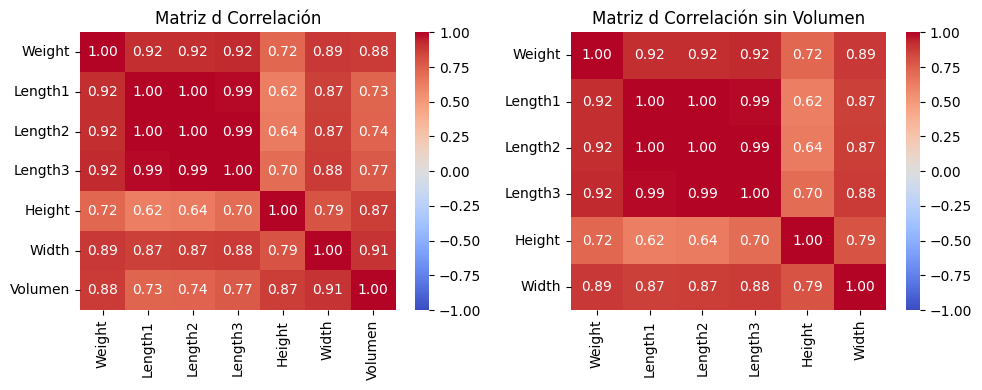

In [49]:
matriz_correlacion = df.select_dtypes(include="number").corr()
matriz_correlacion_sin_volumen = df.select_dtypes(include="number").drop('Volumen', axis=1).corr()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(matriz_correlacion, annot=True, cmap="coolwarm", fmt=".2f",vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title("Matriz de Correlación")

sns.heatmap(matriz_correlacion_sin_volumen, annot=True, cmap="coolwarm", fmt=".2f",vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title("Matriz de Correlación sin Volumen")

plt.tight_layout()
plt.show()

**Resultado**:

- Existe una alta correlación entre las variables. Expecialmente entre las variables de longitud y entre el peso y las demás variables.
- La inclusión de la variable del Volumen no tiene ningún efecto en las demás variables (al comparar las matrices de correlación de ambos gráficos). Sin embargo, si tiene una alta correlación entre el peso y la altura. Esto tiene sentido debido a que el volumen es una variable que es calculada a partir del peso y la altura (variable agregada).  

### 3. Modelo de Regresión
Construye un modelo de regresión lineal que relacione el volumen y el peso de los peces. Realiza una breve evaluación del modelo y grafícalo.

In [50]:
X = df['Weight']  # Variable independiente
Y = df['Volumen'] # Variable dependiente

X_const = sm.add_constant(X)  # agrega intercepto
modelo = sm.OLS(Y, X_const).fit()

print(modelo.summary())

r2 = modelo.rsquared
params = modelo.params          # [const, beta_X]
rmse = np.sqrt(np.mean((modelo.fittedvalues - Y) ** 2))

print('\n')
print('============================================')
print('======== Resumen modelo OLS (Y ~ X) ========')
print(f"Ecuación:  Y = {params.iloc[0]:.3f} + {params.iloc[1]:.3f}·X")
print(f"R² = {r2:.3f} | RMSE = {rmse:.3f}")
print('============================================')

                            OLS Regression Results                            
Dep. Variable:                Volumen   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     544.8
Date:                Sat, 09 Aug 2025   Prob (F-statistic):           9.29e-53
Time:                        02:42:52   Log-Likelihood:                -927.01
No. Observations:                 158   AIC:                             1858.
Df Residuals:                     156   BIC:                             1864.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.5176     10.297      1.604      0.1

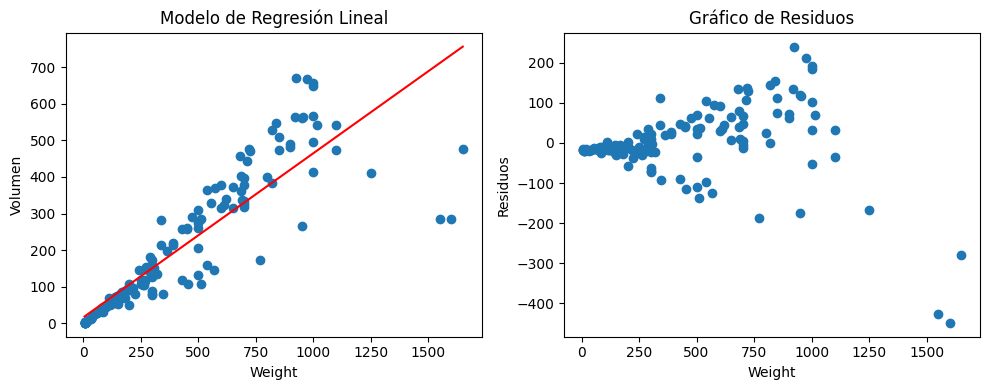

In [51]:
# Crear un rango de valores para X
x_range = np.linspace(X.min(), X.max(), 100)
x_range = sm.add_constant(x_range)
# Obtener las predicciones para el rango de valores
predictions_range = modelo.predict(x_range)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Graficar los datos originales y la línea de regresión
axes[0].scatter(X, Y, label='Datos')
axes[0].plot(x_range[:, 1], predictions_range, color='red', label='Regresión')
axes[0].set_xlabel('Weight')
axes[0].set_ylabel('Volumen')
axes[0].set_title('Modelo de Regresión Lineal')


residuals = modelo.resid
axes[1].scatter(X, residuals)
axes[1].set_xlabel('Weight')
axes[1].set_ylabel('Residuos')
axes[1].set_title('Gráfico de Residuos')

plt.tight_layout()
plt.show()

**Resultado**:

- El modelo líneal, obtenido con OLS, queda como: $Volumen = 17.091 + 0.447·Weight$
- El valor de p es muy bajo lo que indica que la variable independiente Weight tiene un efecto significativo en la variable dependiente Volumen. Esto indica que el peso se relaciona con el volumen.
- Al revisar el gráfico de los residuos se observa que el error no es aleatorio y tampoco está centrado en cero. Esto indica que no se cumple las condiciones de linealidad y homocedasticidad (varianza aumenta al aumentar el valor de Weight). Aunque el peso no tiene una relación líneal con el volumen, si existe una relación.
- Se observa para valores pequeños de peso se ajusta relativamente bien el modelo.
- El valor del intercepto debería ser 0 debido a que para un pez de peso 0, debería tener un valor de Volumen 0 también. Esto es una prueba más para descartar la relación no líneal entre el peso y el Volumen.   

## 4. Relación peso vs volumen desagregado
¿Qué sucede si aplicas el modelo anterior por separado a cada especie de peces? Explica.

Especie: Bream
Ecuación:  Y = -32.527 + 0.649·X
R² = 0.898 | RMSE = 45.159
p-val(const) = 0.0958 | p-val(X) = 3.65e-53

                            OLS Regression Results                            
Dep. Variable:                Volumen   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     289.7
Date:                Sat, 09 Aug 2025   Prob (F-statistic):           6.65e-18
Time:                        02:44:26   Log-Likelihood:                -183.02
No. Observations:                  35   AIC:                             370.0
Df Residuals:                      33   BIC:                             373.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


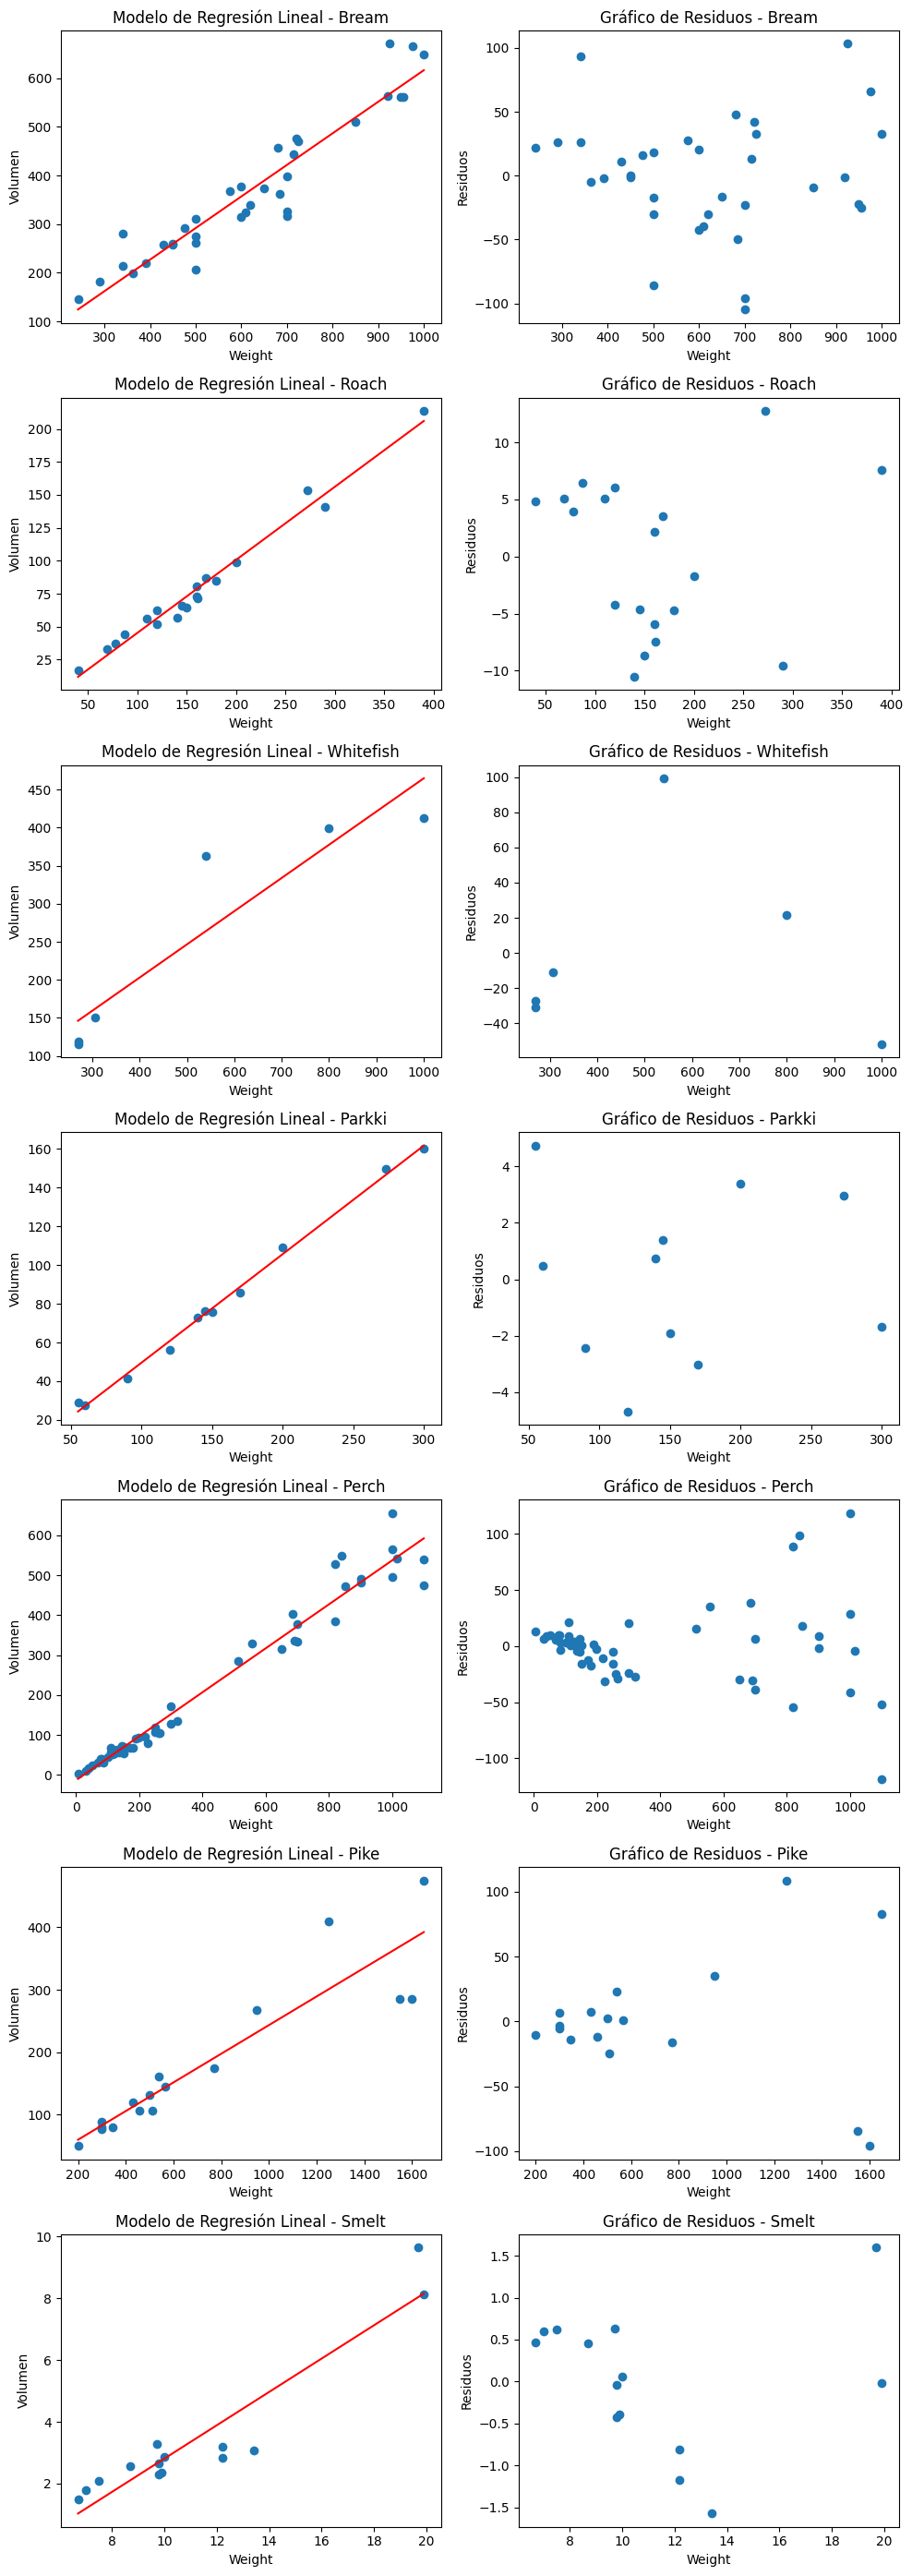

In [53]:
especies = df['Species'].unique()

n_rows = len(especies)
wrap_cols = 2
fig_w = 10
fig_h = 4

fig, axes = plt.subplots(n_rows, wrap_cols,
                         figsize=(fig_w, n_rows * fig_h),
                         sharex=False, sharey=False)

axes = axes.ravel()

def info_especie(especie, axes0, axes1):
  df_especie = df[df['Species'] == especie]
  X = df_especie['Weight']  # Variable independiente
  Y = df_especie['Volumen'] # Variable dependiente

  X_const = sm.add_constant(X)  # agrega intercepto
  modelo = sm.OLS(Y, X_const).fit()


  r2 = modelo.rsquared
  params = modelo.params          # [const, beta_X]
  rmse = np.sqrt(np.mean((modelo.fittedvalues - Y) ** 2))

  print('==============================================================================')
  print(f'Especie: {especie}')
  print('==============================================================================')
  print(f"Ecuación:  Y = {params.iloc[0]:.3f} + {params.iloc[1]:.3f}·X")
  print(f"R² = {r2:.3f} | RMSE = {rmse:.3f}")
  print(f"p-val(const) = {pvals.iloc[0]:.3g} | p-val(X) = {pvals.iloc[1]:.3g}\n")
  print('==============================================================================')
  print(modelo.summary())
  print('==============================================================================')
  print('\n' * 3)

  # Crear un rango de valores para X
  x_range = np.linspace(X.min(), X.max(), 100)
  x_range = sm.add_constant(x_range)
  # Obtener las predicciones para el rango de valores
  predictions_range = modelo.predict(x_range)

  # Graficar los datos originales y la línea de regresión
  axes0.scatter(X, Y, label='Datos')
  axes0.plot(x_range[:, 1], predictions_range, color='red', label='Regresión')
  axes0.set_xlabel('Weight')
  axes0.set_ylabel('Volumen')
  axes0.set_title(f'Modelo de Regresión Lineal - {especie}')


  residuals = modelo.resid
  axes1.scatter(X, residuals)
  axes1.set_xlabel('Weight')
  axes1.set_ylabel('Residuos')
  axes1.set_title(f'Gráfico de Residuos - {especie}')


for i, especie in enumerate(especies):
  info_especie(especie, axes[i * 2], axes[i * 2 + 1])

plt.tight_layout()
plt.show()


**Resultado:**

- Bream
- Roach
- Whitefish
- Parkki
- Perch
- Pike
- Smelt

### 5. Otra relación

Construye un modelo de regresión que relacione dos o más variables con el peso de los peces. Realiza una breve evaluación del modelo



===================== Resumen modelo OLS (Y ~ X1 + X2) =======================
Ecuación:  Y = -505.290 + 21.144·X1 + 79.155·X2
R² = 0.873 | RMSE = 126.915
                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     534.2
Date:                Sat, 09 Aug 2025   Prob (F-statistic):           2.91e-70
Time:                        03:05:23   Log-Likelihood:                -989.47
No. Observations:                 158   AIC:                             1985.
Df Residuals:                     155   BIC:                             1994.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t

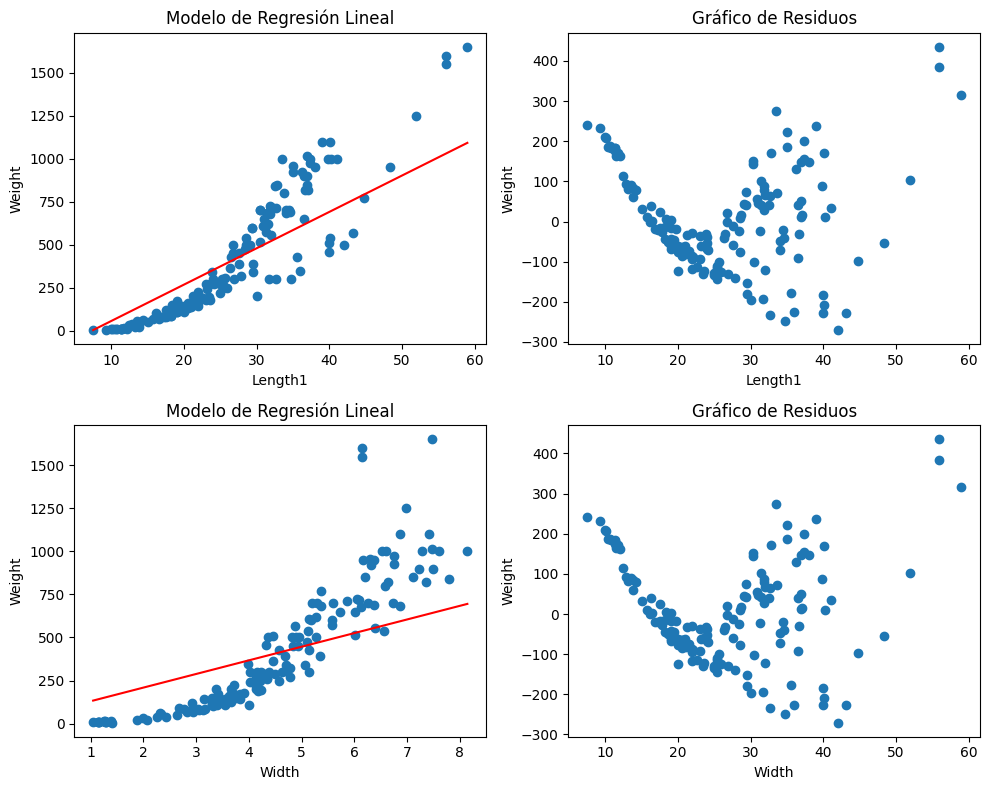

In [61]:
X = df[["Length1", "Width"]]  # Variable independiente
Y = df['Weight'] # Variable dependiente

X1 = X["Length1"]
X2 = X["Width"]

X_const = sm.add_constant(X)  # agrega intercepto
modelo = sm.OLS(Y, X_const).fit()

r2 = modelo.rsquared
params = modelo.params          # [const, beta_X]
rmse = np.sqrt(np.mean((modelo.fittedvalues - Y) ** 2))

print('\n')
print('==============================================================================')
print('===================== Resumen modelo OLS (Y ~ X1 + X2) =======================')
print(f"Ecuación:  Y = {params.iloc[0]:.3f} + {params.iloc[1]:.3f}·X1 + {params.iloc[2]:.3f}·X2")
print(f"R² = {r2:.3f} | RMSE = {rmse:.3f}")
print('==============================================================================')
print(modelo.summary())
print('==============================================================================')

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes = axes.ravel()

# Crear un rango de valores para X1
X1_range = np.linspace(X1.min(), X1.max(), 100)
X2_mean = np.full_like(X1_range, X2.mean())
X_pred = pd.DataFrame({"const": 1, "X1": X1_range, "X2": X2_mean})
Y_pred = modelo.predict(X_pred)

# Graficar los datos originales y la línea de regresión
axes[0].scatter(X1, Y, label='Datos')
axes[0].plot(X1_range, Y_pred, color='red', label='Regresión')
axes[0].set_xlabel('Length1')
axes[0].set_ylabel('Weight')
axes[0].set_title('Modelo de Regresión Lineal')

residuals = modelo.resid
axes[1].scatter(X1, residuals)
axes[1].set_xlabel('Length1')
axes[1].set_ylabel('Weight')
axes[1].set_title('Gráfico de Residuos')

# Crear un rango de valores para X2
X2_range = np.linspace(X2.min(), X2.max(), 100)
X1_mean = np.full_like(X2_range, X1.mean())
X_pred = pd.DataFrame({"const": 1, "X1": X1_mean, "X2": X2_range})
Y_pred = modelo.predict(X_pred)

# Graficar los datos originales y la línea de regresión
axes[2].scatter(X2, Y, label='Datos')
axes[2].plot(X2_range, Y_pred, color='red', label='Regresión')
axes[2].set_xlabel('Width')
axes[2].set_ylabel('Weight')
axes[2].set_title('Modelo de Regresión Lineal')

residuals = modelo.resid
axes[3].scatter(X1, residuals)
axes[3].set_xlabel('Width')
axes[3].set_ylabel('Weight')
axes[3].set_title('Gráfico de Residuos')

plt.tight_layout()
plt.show()